# ML. Ejemplo Modelo Lineal y Regularización

Los datos de este ejercicio provienen de un estudio realizado por Stamey et al. (1989) y es presentado en el capítulo 3 del libro guía "The Elements of Statistical Learning". Stamey et alexaminaron la correlación entre el nivel de antígeno prostático específico (lpsa) y varias medidas clínicas en hombres que estaban a punto de someterse a una prostatectomía radical. Las variables son: volumen de cáncer logarítmico (lcavol), peso prostático logarítmico (lweight), edad, logaritmo de la cantidad de hiperplasia prostática benigna (lbph), invasión de vesículas seminales (svi), logaritmo de la penetración capsular (lcp), puntuación de Gleason (gleason) y porcentaje de puntuaciones de Gleason de 4 o 5 (pgg45).




*Debe formar equipos de entre 2 y 4 personas para abordar las siguientes preguntas de modo consensuado. Designar un secretario que entrega el código y un vocero que expone en caso de ser interpelado.*



1.   ¿Es posible aprender a predecir satisfactoriamente la respuesta (lpsa) en función de los predictores disponibles?
2.   Si asumimos que el modelo lineal es correcto, ¿Qué variables están más relacionadas con la variable respuesta (lpsa)?



<table align='left'>
<tr>
<td><img src='https://assets.roche.com/f/173873/1920x1440/a7d6ecfcda/oncologie-cancer-prostate.jpg/m/768x0/filters:format(webp):quality(90)/' width='650'/>
</tr>
</table>


# Basic Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


import warnings; warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)
plt.rc('axes',titlesize=10)


# Data

In [3]:
!wget http://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv

URL transformed to HTTPS due to an HSTS policy
--2024-09-26 15:47:11--  https://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv
Cargado certificado CA '/etc/ssl/certs/ca-certificates.crt'
Resolviendo www.inf.utfsm.cl (www.inf.utfsm.cl)... 2800:270:c::11, 200.1.19.11
Conectando con www.inf.utfsm.cl (www.inf.utfsm.cl)[2800:270:c::11]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 7129 (7,0K) [application/octet-stream]
Grabando a: «ProstateCancer.csv.5»

ProstateCancer.csv. 100%[===================>]   6,96K  --.-KB/s    en 0s      

2024-09-26 15:47:11 (27,8 MB/s) - «ProstateCancer.csv.5» guardado [7129/7129]



In [4]:
data_raw = pd.read_table('ProstateCancer.csv', sep='\s+')

In [5]:
columns_x = data_raw.columns.tolist()
columns_x.remove("train")   
columns_x.remove("lpsa")    
columns_y = ['lpsa']        #variable objetivo
print(columns_x,columns_y)

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'] ['lpsa']


In [6]:
print(data_raw.head(5))

     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa  \
1 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0 -0.430783   
2 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0 -0.162519   
3 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20 -0.162519   
4 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0 -0.162519   
5  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0  0.371564   

  train  
1     T  
2     T  
3     T  
4     T  
5     T  


Variables:

- **lcavol**: Logaritmo del volumen de material canceroso, medido en mililitros (cc). Este volumen se estimó a partir de imágenes digitalizadas haciendo calculando el área ocupada y multiplicando por un grosor estándar para obtener un volumen.
- **lweight**: Logaritmo del peso de la próstata, medido en gramos.
- **age**: La edad del paciente, en años.
- **lbph**: Logaritmo de la cantidad de hiperplasia prostática benigna (BPH), un agrandamiento no canceroso de la glándula prostática, como un área en una imagen digitalizada y reportada en cm².
- **svi**: Invasión de las vesículas seminales, un indicador binario que indica si las células cancerosas de la próstata han invadido la vesícula seminal (1) o no (0).
- **lcp**: Logaritmo de la penetración capsular, que representa el nivel de extensión del cáncer en la cápsula (el tejido fibroso que actúa como revestimiento externo de la glándula prostática), medido como la extensión lineal de la penetración, en cm.
- **gleason**: Puntaje de Gleason, una medida del grado de agresividad del tumor. El sistema de clasificación de Gleason asigna una calificación (1–5) a cada una de las dos áreas más grandes de cáncer en las muestras de tejido, donde 1 es el menos agresivo y 5 el más agresivo; las dos calificaciones se suman para producir el puntaje de Gleason.
- **pgg45**: Porcentaje de puntuaciones de Gleason que son 4 o 5.
- **lpsa**: Logaritmo del antígeno prostático específico (PSA), una concentración medida en ng/mL.

# Basic Exploratory

In [7]:
ORIG=True
if ORIG:
  dataP = data_raw
else:
  dataP = data_raw[columns_x]
  dataP['lpsa'] = data_raw[columns_y]

In [8]:
dataP.columns

Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45',
       'lpsa', 'train'],
      dtype='object')

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dataP.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,1.35,3.63,63.87,0.10,0.22,-0.18,6.75,24.38,2.48
std,1.18,0.43,7.45,1.45,0.41,1.40,0.72,28.20,1.15
min,-1.35,2.37,41.00,-1.39,0.00,-1.39,6.00,0.00,-0.43
25%,0.51,3.38,60.00,-1.39,0.00,-1.39,6.00,0.00,1.73
50%,1.45,3.62,65.00,0.30,0.00,-0.80,7.00,15.00,2.59
75%,2.13,3.88,68.00,1.56,0.00,1.18,7.00,40.00,3.06
max,3.82,4.78,79.00,2.33,1.00,2.90,9.00,100.00,5.58


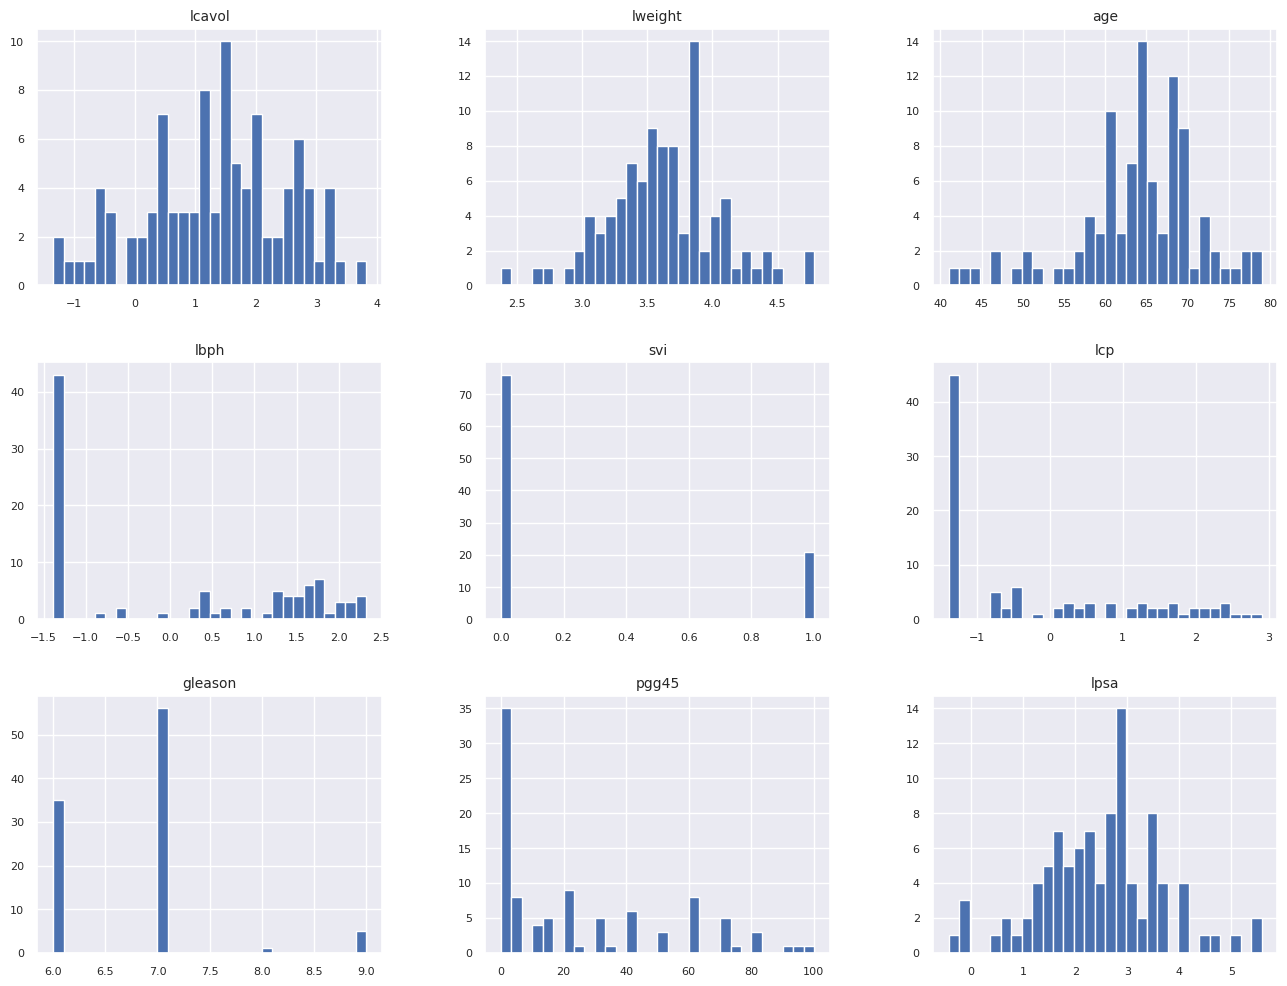

In [10]:
f = dataP.hist(bins=30, figsize=(16, 12))

Observaciones:

*   svi es binaria
*   gleason parece discreta


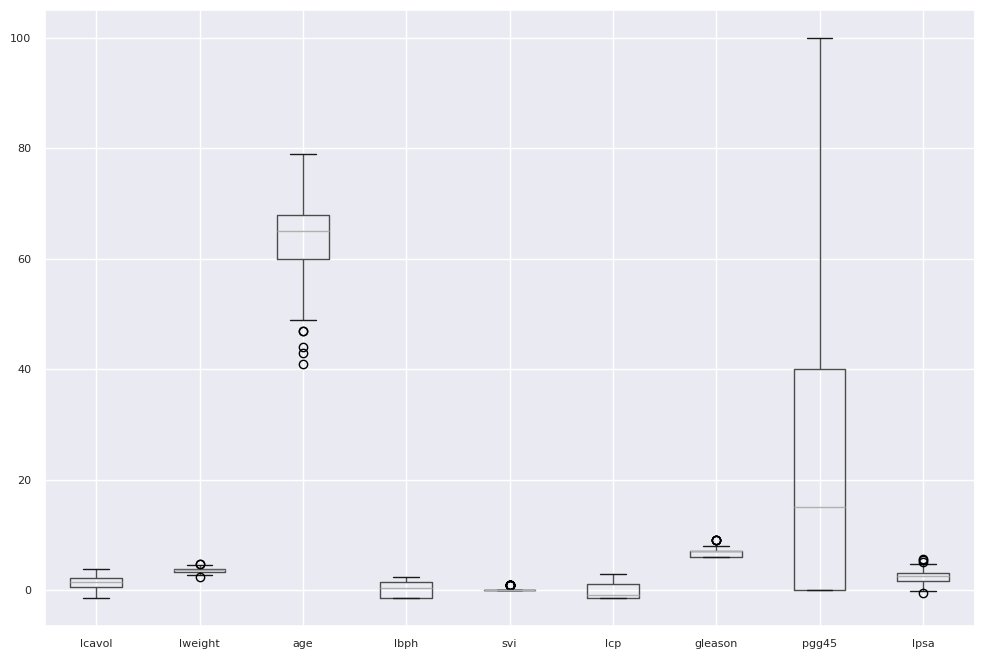

In [11]:
f = dataP.boxplot(figsize=(12, 8))

In [12]:
dataP.columns

Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45',
       'lpsa', 'train'],
      dtype='object')

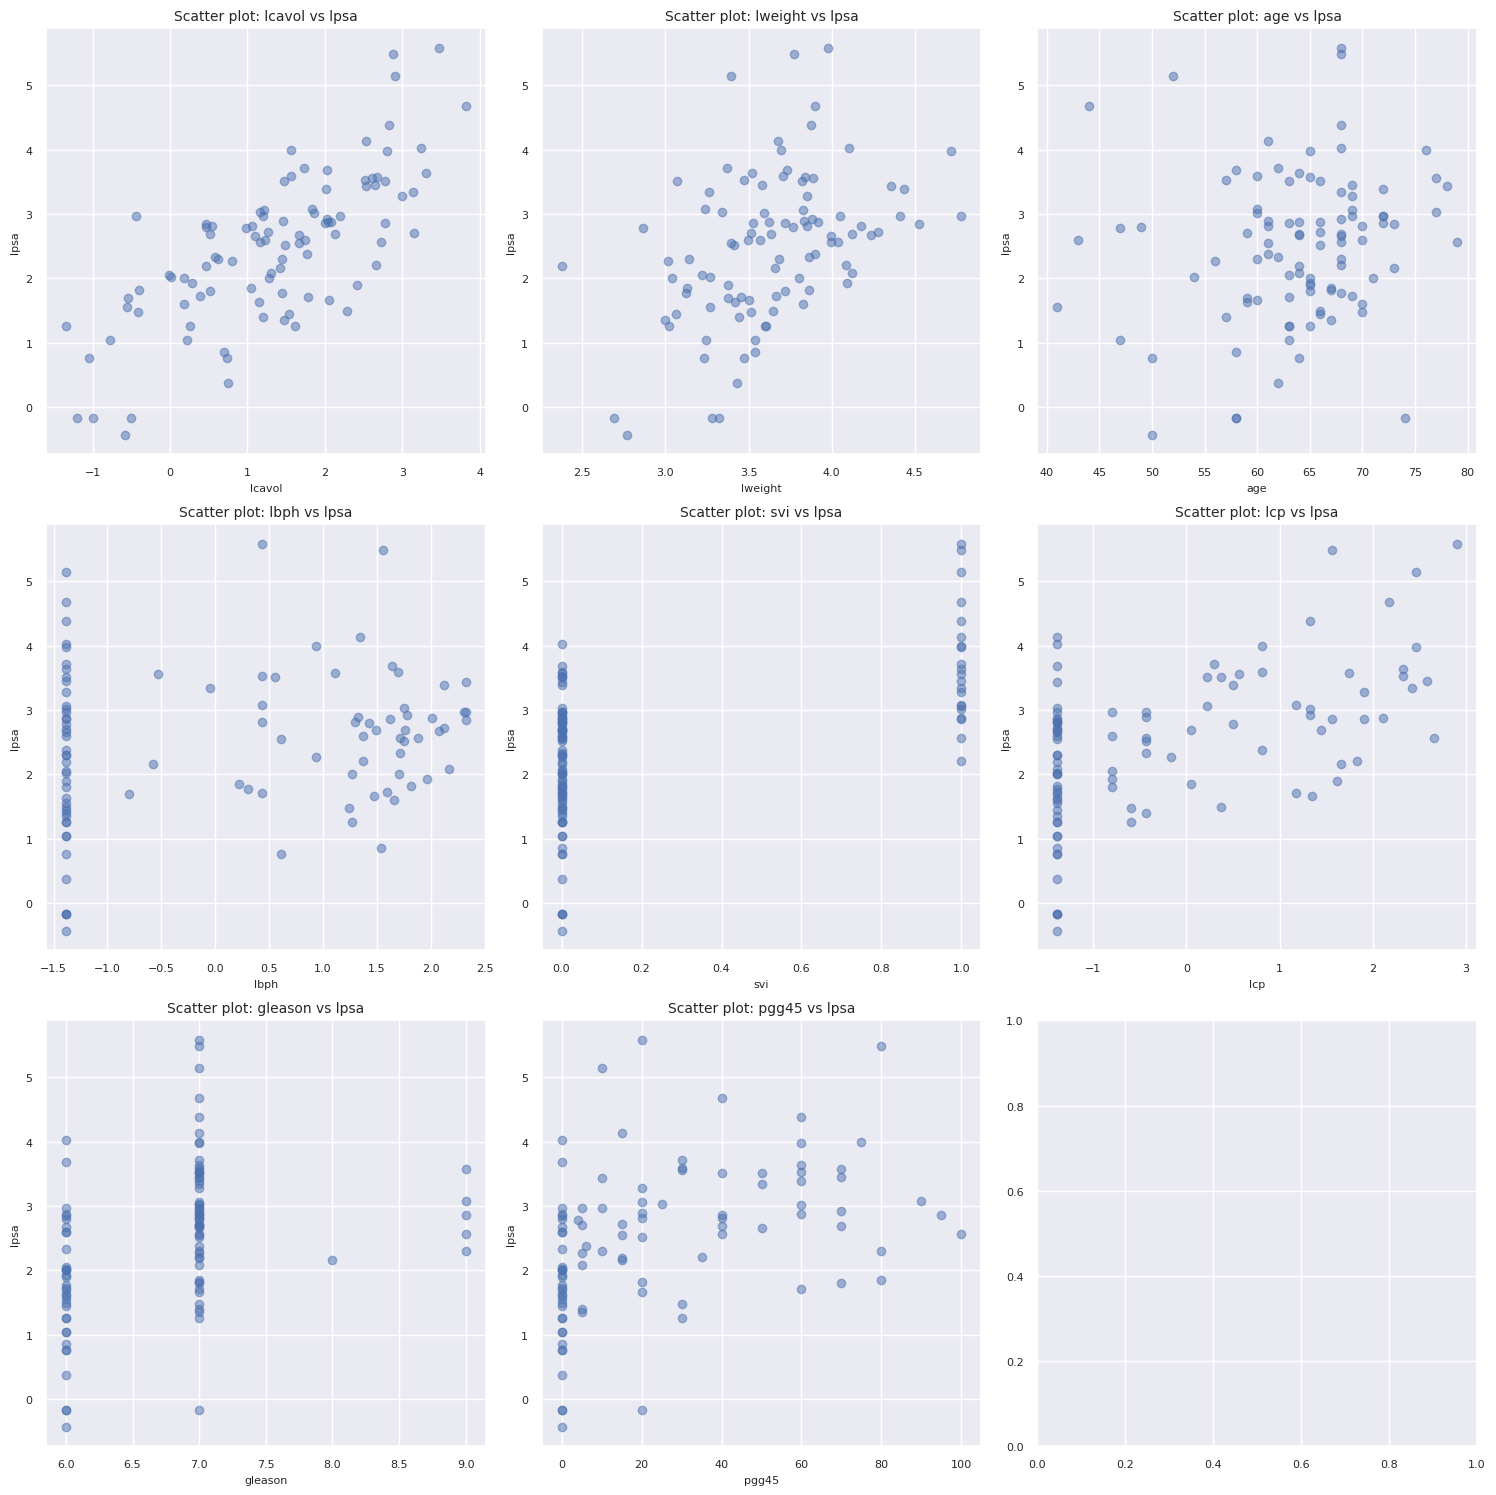

In [13]:
# Crear la figura y los ejes
fig, axes = plt.subplots(3, 3, figsize=(15, 5 * 3))
axes = axes.flatten()  # Aplanar el array de ejes para facilitar el acceso

# Crear los scatter plots
variables = ['lcavol', 'lweight', 'age','lbph', 'svi', 'lcp', 'gleason', 'pgg45'] 
for i, var in enumerate(variables):
    axes[i].scatter(dataP[var], dataP['lpsa'], alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('lpsa')
    axes[i].set_title(f'Scatter plot: {var} vs lpsa')

# Ajustar el layout
plt.tight_layout()

# Pre-processing

In [14]:
data = pd.get_dummies(data_raw, prefix=['gleason'], columns=['gleason'], dtype=int)
columns_x = data.columns.tolist()
columns_x.remove("train")
columns_x.remove("lpsa")
columns_y = ['lpsa']
print(columns_x,columns_y)

training_data = data[data['train']=='T'].drop(columns=['train'])
test_data = data[data['train']!='T'].drop(columns=['train'])

print("Training N:", len(training_data), "from NTotal:",len(data))
print("Test N:",len(test_data),"from NTotal:",len(data))

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45', 'gleason_6', 'gleason_7', 'gleason_8', 'gleason_9'] ['lpsa']
Training N: 67 from NTotal: 97
Test N: 30 from NTotal: 97


In [15]:
print(training_data.head(5))

   lcavol  lweight  age  lbph  svi   lcp  pgg45  lpsa  gleason_6  gleason_7  \
1   -0.58     2.77   50 -1.39    0 -1.39      0 -0.43          1          0   
2   -0.99     3.32   58 -1.39    0 -1.39      0 -0.16          1          0   
3   -0.51     2.69   74 -1.39    0 -1.39     20 -0.16          0          1   
4   -1.20     3.28   58 -1.39    0 -1.39      0 -0.16          1          0   
5    0.75     3.43   62 -1.39    0 -1.39      0  0.37          1          0   

   gleason_8  gleason_9  
1          0          0  
2          0          0  
3          0          0  
4          0          0  
5          0          0  


In [16]:
from sklearn import preprocessing

cont_predictors = ['lcavol', 'lweight', 'age','lbph', 'lcp', 'pgg45'] #svi es binaria
X_train = training_data.loc[:, training_data.columns != 'lpsa']
y_train = np.expand_dims(training_data['lpsa'].values,axis=1)

X_test = test_data.loc[:, test_data.columns != 'lpsa']
y_test = np.expand_dims(test_data['lpsa'].values,axis=1)

## Scaling

In [164]:
x_scaler = preprocessing.StandardScaler().fit(X_train[cont_predictors])
y_scaler = preprocessing.StandardScaler().fit(y_train)

X_train[cont_predictors] = x_scaler.transform(X_train[cont_predictors])
X_test[cont_predictors] = x_scaler.transform(X_test[cont_predictors])

y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [23]:
zscore = (X_test-X_test.mean())/X_test.std()
zscore

,lcavol,lweight,age,lbph,svi,lcp,pgg45,gleason_6,gleason_7,gleason_8,gleason_9
7,-0.67,-0.54,0.30,0.31,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
9,-2.13,-0.32,-2.12,-1.07,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
10,-1.17,-1.30,0.16,-1.07,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
15,-0.22,-0.64,-0.70,-1.07,-0.49,-0.23,-0.59,-0.70,0.80,NaN,-0.26
22,0.61,-0.45,-0.27,0.91,-0.49,1.03,-0.01,-0.70,0.80,NaN,-0.26
25,-1.01,0.11,1.01,0.99,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
26,0.01,-1.70,0.87,0.09,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
28,-1.77,0.77,0.72,1.14,-0.49,-0.91,-0.01,-0.70,0.80,NaN,-0.26
32,-1.21,0.56,0.44,1.07,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26
34,-1.37,-1.22,-1.12,-1.07,-0.49,-0.91,-0.79,1.39,-1.20,NaN,-0.26


# SVD visita ML

In [236]:
from sklearn import linear_model
from sklearn import metrics

Primero lo que se hará será calcular la descomposición SVD de la matriz de diseño.

In [237]:
U, S, Vh =  np.linalg.svd(X_train)
U.shape, S.shape, Vh.shape

((67, 67), (11,), (11, 11))

Como `linalg.svd` de np retorna a S como un vector $n x n$ para transformarlo en la matriz diagonal sigma $mxn$ correspondiente:

In [238]:
Sigma = np.zeros((X_train.shape[0], X_train.shape[1]))
Sigma[ :X_train.shape[1], :X_train.shape[1]] = np.diag(S) #se reemplaza la porción superior nxn por la diagonal correspondiente
Sigma.shape

(67, 11)

In [239]:
StS = Sigma.T @ Sigma
StS.shape

(11, 11)

Comprobamos la varianza de cada PC

In [240]:
PC = U @ Sigma
totalVar = np.sum(S**2)
varExplain = (S**2)/totalVar
PC.shape, varExplain.shape

((67, 11), (11,))

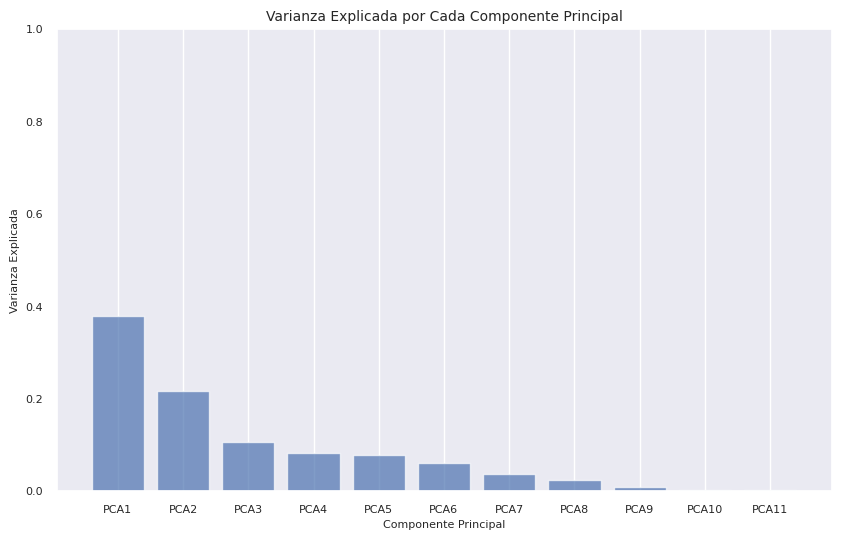

In [241]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(varExplain) + 1), varExplain, alpha=0.7)
plt.title('Varianza Explicada por Cada Componente Principal')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.xticks(range(1, len(varExplain) + 1), [f'PCA{i+1}' for i in range(len(varExplain))])
plt.ylim(0, 1)  # Establecer el rango del eje y
plt.grid(axis='y')

In [242]:
np.sum(varExplain[0:9])

np.float64(0.9950504101172676)

Ahora que sabemos los componentes que tienen mayor relevancia, proyectamos nuestra matriz de diseño a un espacio que reduce su dimensionalidad. Esta transformación la aplicamos tanto a x_train como a x_test

In [243]:
n_componentes = 9
U[:, :n_componentes].shape, Sigma[:n_componentes, :n_componentes].shape, np.diag(S[:n_componentes]).shape

((67, 9), (9, 9), (9, 9))

In [244]:
n_componentes = 9

X_train_red =  U[:, :n_componentes] @ Sigma[:n_componentes, :n_componentes]
X_test_red = X_test @ Vh.T[:, :n_componentes]

X_train_red.shape, X_test_red.shape

((67, 9), (30, 9))

Ahora sabemos que con este nuevo espacio aproximamos al 92.5% la matriz original! Entrenaremos el modelo y veremos las diferencias.

In [245]:
regRed = linear_model.LinearRegression()
regRed.fit(X_train_red, y_train)

LinearRegression()

In [246]:
y_pred_red = regRed.predict(X_test_red)

### Resultados

In [247]:
def results(U, Sigma, X_test):
    r = {'MSE':[], 'MAE':[], 'R**2':[] }

    for n_componentes in range(1, X_test.shape[1] + 1):

        X_train_red =  U[:, :n_componentes] @ Sigma[:n_componentes, :n_componentes]
        X_test_red = X_test @ Vh.T[:, :n_componentes]

        regRed = linear_model.LinearRegression()
        regRed.fit(X_train_red, y_train)

        y_pred_red = regRed.predict(X_test_red)

        r['MSE'].append(metrics.mean_squared_error(y_test, y_pred_red))
        r['MAE'].append(metrics.mean_absolute_error(y_test, y_pred_red))
        r['R**2'].append(metrics.r2_score(y_test, y_pred_red))
    
    return r
    


In [248]:
r = results(U, Sigma, X_test)

len(r['MSE']) , len(r['MAE']), len(r['R**2'])

(11, 11, 11)

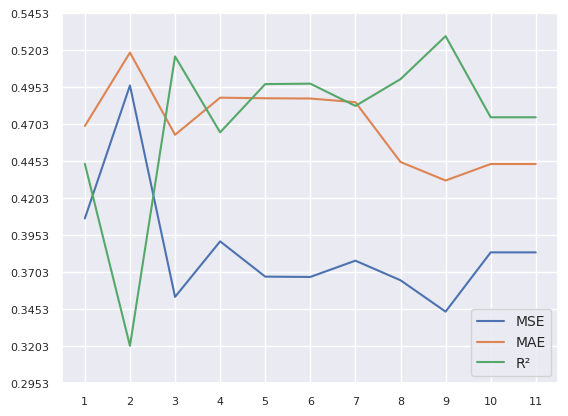

In [249]:
fig, ax = plt.subplots()
ax.plot(range(1,12), r['MSE'], label='MSE')
ax.plot(range(1,12), r['MAE'], label='MAE')
ax.plot(range(1,12), r['R**2'], label='R²')

ax.legend()
# Configurar etiquetas en el eje X
ax.set_xticks(range(1, 12))  # Asegúrate de que se muestren todas las etiquetas

yticks = np.arange(min(min(r['MSE']), min(r['MAE']), min(r['R**2'])) - 0.025
                   , max(max(r['MSE']), max(r['MAE']), max(r['R**2'])) + 0.025, 0.025)
ax.set_yticks(yticks)

plt.show()

Al parecer seleccionar una dimensionalidad utilizando 9 vectores propios es el óptimo

## Zscore